# Image Classification Confusion Matrix

In [1]:
import gdal
import numpy as np
import pandas as pd

In [2]:
#load image as array
original_image = gdal.Open('Assignment/aviris_hyperspectral_data/19920612_AVIRIS_IndianPine_Site3.tif')
image_pixels = original_image.ReadAsArray()
image_pixels.shape

(220, 145, 145)

In [3]:
#reshape image pixels
nbands, nrows, ncols = image_pixels.shape
row_value = image_pixels.transpose(1, 2, 0).reshape((nrows*ncols, nbands))
np.testing.assert_array_equal(row_value[2], image_pixels[:, 0, 2])
print(row_value.shape)

(21025, 220)


In [4]:
#load clr file
clr_data = pd.read_csv('Assignment/documentation/Site3_Project_and_Ground_Reference_Files/19920612_AVIRIS_IndianPine_Site3_gr.clr', header=None, delim_whitespace=True, names= ["A", "B", "C", "D", "E"]) 

#to clean-up label in clr table
for i in range(len(clr_data)):
    clr_data.iloc[i,4][2:][:-1]

In [5]:
#load reference image as array
ref_data = gdal.Open('Assignment/documentation/Site3_Project_and_Ground_Reference_Files/19920612_AVIRIS_IndianPine_Site3_gr.tif')
ref_data_pixels = ref_data.ReadAsArray()
ref_data_pixels.shape

(145, 145)

In [6]:
nrows, ncols = ref_data_pixels.shape
row_val_ref_data = ref_data_pixels.reshape((nrows*ncols, 1))
np.testing.assert_array_equal(row_val_ref_data[1], ref_data_pixels[0, 1])
print(row_val_ref_data.shape)

(21025, 1)


In [7]:
#recode values in ground reference data
ref_dict = {0:0, 1:1, 2:2, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:5, 10:6, 11:6, 12:6, 13:7, 14:8, 15:8, 16:0}

row_value_ref = []
for i in row_val_ref_data:
    row_value_ref.append([ref_dict[i[0]]])
    
#convert from list to array
row_value_ref_arr = np.array(row_value_ref)

In [8]:
new_table = np.zeros((21025, 221))
new_table.shape

(21025, 221)

In [9]:
new_table = np.empty((21025, 221),dtype=float)
new_table[:,:-1] = row_value
new_table[:,-1:] = row_value_ref_arr

In [10]:
#eliminate labels with zero values (not part of the reference data)
new_array = []

for i in range(len(new_table)):
    if new_table[i, -1] !=0:
        new_array.append(new_table[i, :])

In [11]:
ground_reference = pd.DataFrame(new_array) 

ground_reference.head()

,0,1,2,3,4,5,6,7,8,9,...,211,212,213,214,215,216,217,218,219,220
0,3172.0,4142.0,4506.0,4279.0,4782.0,5048.0,5213.0,5106.0,5053.0,4750.0,...,1090.0,1112.0,1090.0,1062.0,1069.0,1057.0,1020.0,1020.0,1005.0,2.0
1,3348.0,4266.0,4502.0,4426.0,4853.0,5249.0,5352.0,5353.0,5347.0,5065.0,...,1104.0,1117.0,1091.0,1079.0,1085.0,1064.0,1029.0,1020.0,1000.0,2.0
2,3687.0,4266.0,4421.0,4498.0,5019.0,5293.0,5438.0,5427.0,5383.0,5132.0,...,1114.0,1114.0,1100.0,1065.0,1092.0,1061.0,1030.0,1016.0,1009.0,2.0
3,3517.0,4258.0,4603.0,4493.0,4958.0,5234.0,5417.0,5355.0,5349.0,5096.0,...,1108.0,1109.0,1109.0,1071.0,1088.0,1060.0,1030.0,1006.0,1005.0,2.0
4,3514.0,4018.0,4675.0,4417.0,4886.0,5117.0,5215.0,5096.0,5098.0,4834.0,...,1107.0,1112.0,1094.0,1072.0,1087.0,1052.0,1034.0,1019.0,1019.0,2.0


In [12]:
#train-test-split
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split( 
    ground_reference.iloc[:, 0:220],
    ground_reference.iloc[:, 220],
    stratify=ground_reference.iloc[:, 220],
    test_size=0.50,
    random_state=42
)

print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)

(5135, 220)
(5136, 220)
(5135,)
(5136,)


In [13]:
#variable selection using recursive feature elimination

from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=33)

rfe.fit(x_train, y_train)

for i in range(x_train.shape[1]):
    'Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i])
    
x_training = x_train.loc[:, rfe.support_]
x_validation = x_validate.loc[:, rfe.support_]
print(x_training.shape)
print(x_validation.shape)

(5135, 33)
(5136, 33)


In [14]:
#hyper-parameter selection

from sklearn import model_selection
from sklearn import ensemble
param_grid = {
    'bootstrap': [True],
    'max_depth': [8],
    'max_features': [33],
    'min_samples_leaf': [6, 7, 8],
    'min_samples_split': [7],
    'n_estimators': [200, 250]
}
rf = ensemble.RandomForestClassifier()
grid_search = model_selection.GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(x_training, y_train)
params = grid_search.best_params_
params

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   24.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   31.0s finished


{'bootstrap': True,
 'max_depth': 8,
 'max_features': 33,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 250}

In [15]:
rforest = ensemble.RandomForestClassifier(
    bootstrap=params['bootstrap'],
    max_depth=params['max_depth'],
    max_features=params['max_features'],
    min_samples_leaf=params['min_samples_leaf'],
    min_samples_split=params['min_samples_split'],
    n_estimators=params['n_estimators'],
    random_state=42
)
rforest.fit(x_training, y_train);

In [16]:
rpred = rforest.predict(x_validation)

In [17]:
from sklearn.metrics import confusion_matrix
all_classes = ground_reference[220].unique()

cm = confusion_matrix(
    y_validate,
    rpred,
    labels=all_classes
    
)

print(cm)

[[ 859    2  379   10    1    0    0    0]
 [   0  736    0   84    0    0    1   16]
 [ 146    0 1858   21    0    0    0    0]
 [   2   18    3  600   12    0    0    0]
 [   0    0    0   10  233    0    2    0]
 [   0    2    0    8    0    0    0    0]
 [   0    0    3    2    8    0   14    0]
 [   0    1    1    7    0    0    0   97]]


In [18]:
#normalize confusion matrix

cmn = cm/21025
print(cmn)

[[4.08561237e-02 9.51248514e-05 1.80261593e-02 4.75624257e-04
  4.75624257e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.50059453e-02 0.00000000e+00 3.99524376e-03
  0.00000000e+00 0.00000000e+00 4.75624257e-05 7.60998811e-04]
 [6.94411415e-03 0.00000000e+00 8.83709869e-02 9.98810939e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.51248514e-05 8.56123662e-04 1.42687277e-04 2.85374554e-02
  5.70749108e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.75624257e-04
  1.10820452e-02 0.00000000e+00 9.51248514e-05 0.00000000e+00]
 [0.00000000e+00 9.51248514e-05 0.00000000e+00 3.80499405e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.42687277e-04 9.51248514e-05
  3.80499405e-04 0.00000000e+00 6.65873960e-04 0.00000000e+00]
 [0.00000000e+00 4.75624257e-05 4.75624257e-05 3.32936980e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.61355529e-03]]

In [19]:
#change labels to string

new_dict = {0:'Other', 1:'Alfalfa', 2:'Corn', 3:'Grass', 4:'Hay', 5:'Oats', 6:'Soybeans', 7:'Wheat', 8:'Trees'}

#convert to list

all_classes_new = []
for i in all_classes:
    all_classes_new.append(new_dict[i])

<IPython.core.display.Javascript object>


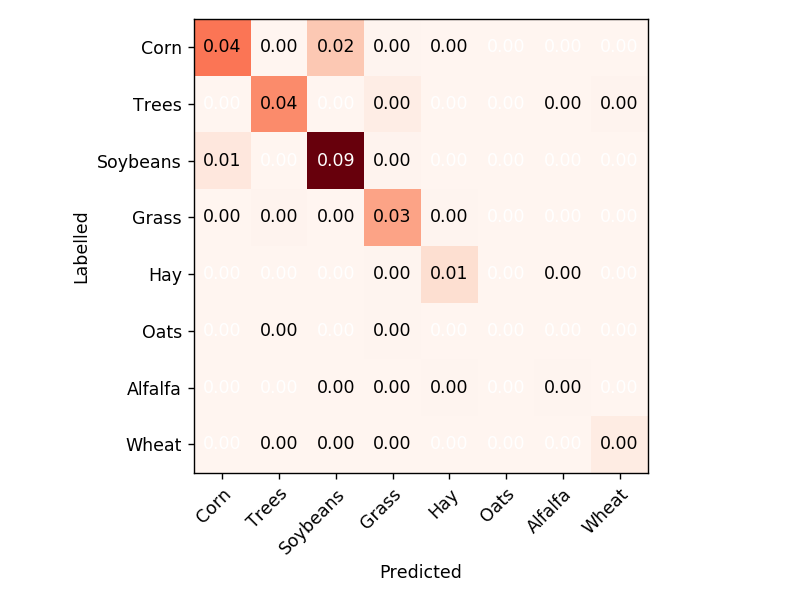

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = plt.subplots()
ax.imshow(cmn, interpolation='nearest', cmap=plt.cm.Reds)

ax.set_xticks(np.arange(len(all_classes_new)))
ax.set_yticks(np.arange(len(all_classes_new)))

ax.set_xticklabels(all_classes_new)
ax.set_yticklabels(all_classes_new)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

thresh = cmn.max() / 2.
for i in range(len(all_classes_new)):
    for j in range(len(all_classes_new)):
        text = ax.text(j, i, '{0:.2f}'.format(cmn[i, j]),
                       ha="center", va="center",
                       color="w" if (cmn[i, j] > thresh)or(cmn[i, j]==0.) else "k")

ax.set_ylabel('Labelled')
ax.set_xlabel('Predicted')
ax.set_ylim(len(all_classes_new)-0.5, -0.5)
fig.tight_layout()

In [22]:
class_ii = cm.diagonal()
user = np.zeros(class_ii.shape)
user[class_ii!=0] = class_ii[class_ii!=0]/cm[:, class_ii!=0].sum(axis=0)
prod = np.zeros(class_ii.shape)
prod[class_ii!=0] = class_ii[class_ii!=0]/cm[class_ii!=0, :].sum(axis=1)

print(pd.DataFrame(
    data={'class':all_classes_new, 
          'User': user,
          'Prod': prod
         }))
print('Overall = {}'.format(class_ii.sum()/cm.sum()))

      class      User      Prod
0      Corn  0.853029  0.686651
1     Trees  0.969697  0.879331
2  Soybeans  0.827986  0.917531
3     Grass  0.808625  0.944882
4       Hay  0.917323  0.951020
5      Oats  0.000000  0.000000
6   Alfalfa  0.823529  0.518519
7     Wheat  0.858407  0.915094
Overall = 0.856113707165109
